## ch04 Tree Creation
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.18</div>
<div style="text-align: right"> Last update: 2023.7.18</div>

In [7]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

### 4.1 The Gini Coefficient

지니계수는 빈도 분포에서 불평등 레벨을 계량화 한것이다.  
- 0 : 완전 평등  
- 1 : 값들 간 최대의 불평등  

$$Gini = 1 - \sum_{i=1}^{c}{p_{i}^2}$$

- 위에서 c는 클래스의 수이다.  
- pi는 클래스 i의 관측 비율이다.

최적의 트리 splitting을 이해하기 위해 두개 클래스와 2개 피처를 가지는 데이터셋을 만들어 실험한다.  
일부 피처 클래스가 겹친다. 즉 트리 분할 양쪽 모두에 클래스 관측 값이 있다.   

우리는 올바를 클래스로 나누는 피처 threshold를 찾아본다.

두개의 랜덤 변수를 만들고 positive, negative로 레이블링 해보자.

In [8]:
import numpy as np
import numpy.random as rn

In [9]:
pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))

In [10]:
gini = pd.DataFrame(
    {
        'value': np.append((pos_center) + rs.randn(pos_count), (neg_center) + rs.randn(neg_count)),
        'label': ['pos']*pos_count + ['neg']*neg_count
    }
)

In [11]:
gini

,value,label
0,14.210352,pos
1,12.775662,pos
2,12.346531,pos
3,12.977911,pos
4,13.146511,pos
...,...,...
1095,6.633856,neg
1096,6.116057,neg
1097,6.586057,neg
1098,6.990318,neg


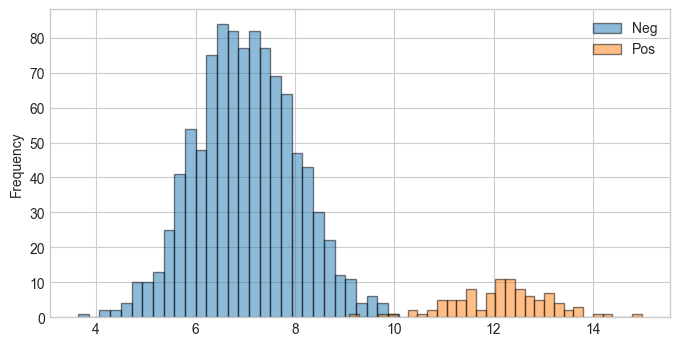

In [12]:
fig, ax = plt.subplots(figsize = (8, 4))

_ = (gini
     .groupby('label')
     [['value']]
     .plot.hist(bins = 30, alpha = .5, ax = ax, edgecolor = 'black')
     )
ax.legend(['Neg', 'Pos'])

- 9 ~ 10 사이에 오버랩이 있다.

이제 피처를 보고 값이 pos, neg 인지 결정해야 한다고 가정해보자.  
지니계수가 도움이 될 수 있다.  
지니계수를 계산하려면 pos, neg 결정 지점(split_point)를 고려해야한다.   


실제 레이블이 있으면, true positive, false positive, true negative, and false negative를 계한할 수 있다.  
그런 다음 1에서 TP와 FP의 비율을 제곱한 값을 뺀 가중 평균을 계산합니다.   
또한 가중 평균에서 1을 뺸 값에서 TP, FP의 비율의 제곱을 계산한다.    

이 두 값의 가중 평균이 지니계수이다.